# An Attempt at a Multimodal Transit Accessibility Model for Westchester County, New York

## Background

   Transportation accessibility is becoming a particular topic of interest in the transportation geography community as urban areas shift toward public transportation as the main method of transportation. Accessibility is best defined as the suitability of the transportation system to move people from where they board to where they exit in a reasonable amount of time. It can mostly be measured using travel time, required transfers, and the regularity / frequency of service. Since there are a wider variety of people utilizing public transit, it’s important that transportation equity is a priority in transportation planning to better serve our community. 
    
   The study area for this was Westchester County, New York. It is located just north of the Bronx and has an estimated population of 980,244 for 2017. I chose Westchester mostly because I'm from there, and many of these sorts of accessibility studies focus on major city regions (like New York City) that have large focuses on walkability, while leaving out suburbs. I wanted to see what I could do with a large suburban county.
    
## Step 1: Construct the multimodal network
> Import the libraries

In [16]:
# peartree functions aren't up to date, ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import peartree as pt
import osmnx as ox
import networkx as nx
import pickle

I used GTFS (General Transit Feed Specification) data, which is a standard developed by Google for transit authorities to publish their data in a standardized format. This data is the latest (March 29, 2019) for the Bee-Line Bus System that runs the bus network in Westchester County.

Below is a function that uses the peartree library to build a NetworkX object of the bus system for Westchester County. It creates the graph based on the busiest path in the feed and the impedance time, and then pickles the graph for later use.

In [18]:
# function to create the bus route networks

def create_busroutes(starttime, endtime, existing_graph, outputpickle):
    path = 'data\\Westchester_County_Bee-Line_System.zip'
    feed = pt.get_representative_feed(path)

    # set a target time period to use to summarize impedance
    start = starttime
    end = endtime

    # converts feed subset into a directed network multigraph
    G = pt.load_feed_as_graph(feed, start, end, existing_graph)
    
    # pickle the graph to use later without running the function again
    with open(outputpickle, 'wb') as pkl_file:
        pickle.dump(G, pkl_file)
    
    return G

I had intended to run analyses on morning peak, afternoon peak, and offpeak networks but this proved to be difficult. I still leave this here to demonstrate how easy it is to make these graphs from the GTFS data.

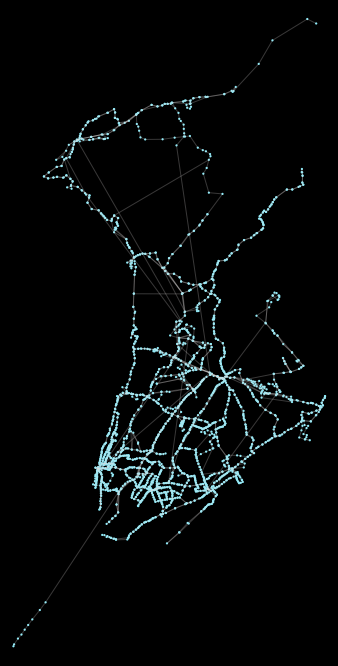

In [19]:
# create morning peak, afternoon peak, and offpeak networks

if not os.path.exists('am_buses.pkl'):
    ampeak = create_busroutes(6*60*60, 9*60*60, None, 'am_buses.pkl') # 6:00AM to 9:00AM
else:
    with open('am_buses.pkl', 'rb') as pkl_file:
        ampeak = pickle.load(pkl_file)
    
if not os.path.exists('pm_buses.pkl'):
    pmpeak = create_busroutes(16*60*60, 19*60*60, None, 'pm_buses.pkl') # 4:00PM to 7:00PM
else:
    with open('pm_buses.pkl', 'rb') as pkl_file:
        pmpeak = pickle.load(pkl_file)
        
if not os.path.exists('offpeak_buses.pkl'):
    offpeak = create_busroutes(9*60*60, 16*60*60, None, 'offpeak_buses.pkl') # 9:00AM to 4:00PM
else:
    with open('offpeak_buses.pkl', 'rb') as pkl_file:
        offpeak = pickle.load(pkl_file)
        
# the networks would look the same, let's view one of them
pt.generate_plot(ampeak);

The next step is getting the walking network from OpenStreetMap. This uses OSMnx which excels at querying and pulling this type of data. This is also a NetworkX graph.

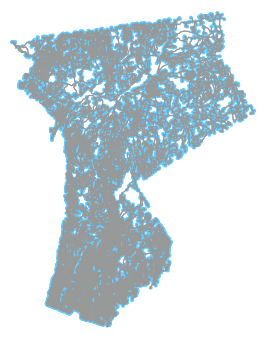

In [20]:
# create the pedestrian network and save as a pickle file

if not os.path.exists('walking.pkl'):
    walknx = ox.graph_from_place('Westchester County, New York, USA', network_type='walk')

    with open('walking.pkl', 'wb') as pkl_file:
        pickle.dump(walknx, pkl_file)
else:
    with open('walking.pkl', 'rb') as pkl_file:
        walknx = pickle.load(pkl_file)
        
# plot the network
fig, ax = ox.plot_graph(walknx)

Let's look at the structure of the edges for the two graphs so we know the best way to merge them.

In [21]:
# edge structure of the peartree graph
list(ampeak.edges(data=True))[0]

('5986010', '59860627', {'length': 68.25, 'mode': 'transit'})

In [22]:
# OSMnx graph
list(walknx.edges(data=True))[0]

(254803973,
 254803979,
 {'osmid': 23529879,
  'name': 'Algonquin Drive',
  'highway': 'residential',
  'oneway': False,
  'length': 127.776,
  'geometry': <shapely.geometry.linestring.LineString at 0x257219b0e10>})

One has their length measured in seconds (travel time) and the other has their length measured in meters (actual distance). Since I'm using travel time as the impedance and measurement of accessibility, let's convert the OSMnx graph to have edge measurements in seconds based on walking speed.

In [23]:
walk_speed = 4.5  # kmph - about 3 mph

# make a copy of the graph
walknx_copy = walknx.copy()

# convert length in meters to seconds
for from_node, to_node, edge in walknx_copy.edges(data=True):
    orig_len = edge['length']
    
    # there could be multiple edges here but I'm assuming there isn't
    walknx_copy[from_node][to_node][0]['orig_length'] = orig_len

    # conversion of walk speed and into seconds from meters
    kmph = (orig_len / 1000) / walk_speed
    in_seconds = kmph * 60 * 60
    walknx_copy[from_node][to_node][0]['length'] = in_seconds
    
    # add a walk mode to match the transit mode
    walknx_copy[from_node][to_node][0]['mode'] = 'walk'

In [24]:
# now have both length values
list(walknx_copy.edges(data=True))[0]

(254803973,
 254803979,
 {'osmid': 23529879,
  'name': 'Algonquin Drive',
  'highway': 'residential',
  'oneway': False,
  'length': 102.2208,
  'geometry': <shapely.geometry.linestring.LineString at 0x257219b0e10>,
  'orig_length': 127.776,
  'mode': 'walk'})

In [25]:
# change the boarding cost on the nodes for walking
for i, node in walknx_copy.nodes(data=True):
    walknx_copy.node[i]['boarding_cost'] = 0

list(walknx_copy.nodes(data=True))[0]

(254803973,
 {'y': 41.0493634, 'x': -73.847934, 'osmid': 254803973, 'boarding_cost': 0})

We can now overlay these two graphs on top of each other and create the multimodal network, again using peartree. I'm doing this solely for the morning peak times.

In [26]:
# since the walk and transit network are formatted the same, we can overlay them

# impedance
start = 6 * 60 * 60
end = 9 * 60 * 60

# reload the transit network onto the walk network
if not os.path.exists('multimodal.pkl'):
    path = 'data\\Westchester_County_Bee-Line_System.zip'
    feed = pt.get_representative_feed(path)
    %time ampeak2 = pt.load_feed_as_graph(feed, start, end, existing_graph=walknx)

    with open('multimodal.pkl', 'wb') as pkl_file:
        pickle.dump(ampeak2, pkl_file)
else:
    with open('multimodal.pkl', 'rb') as pkl_file:
        ampeak2 = pickle.load(pkl_file)

When you do this, there are some bad nodes that don't connect to anything. We can remove them easily by looping through the nodes.

In [27]:
# this is an issue that needs cleaning up
print('All nodes', len(ampeak2.nodes()))
bad_ns = [i for i, n in ampeak2.nodes(data=True) if 'x' not in n]
print('Bad nodes count', len(bad_ns))

for bad_n in bad_ns:
    # check to see if they connect to anything
    if len(ampeak2[bad_n]) > 0:
        print(bad_n)

    else:
        # So just drop them
        ampeak2.remove_node(bad_n)

All nodes 46535
Bad nodes count 3123


In [28]:
len(ampeak2.nodes(data=True))

43412

In [29]:
len(ampeak2.edges(data=True))

113348

We can plot the network now! Using the plotting parameters from OSMnx, we can get the edge colors to match the value of the 'length' attribute, which directly corresponds to travel time in seconds. The lighter the color, the longer it takes to travel that edge. You can definitely make out the transit network here.

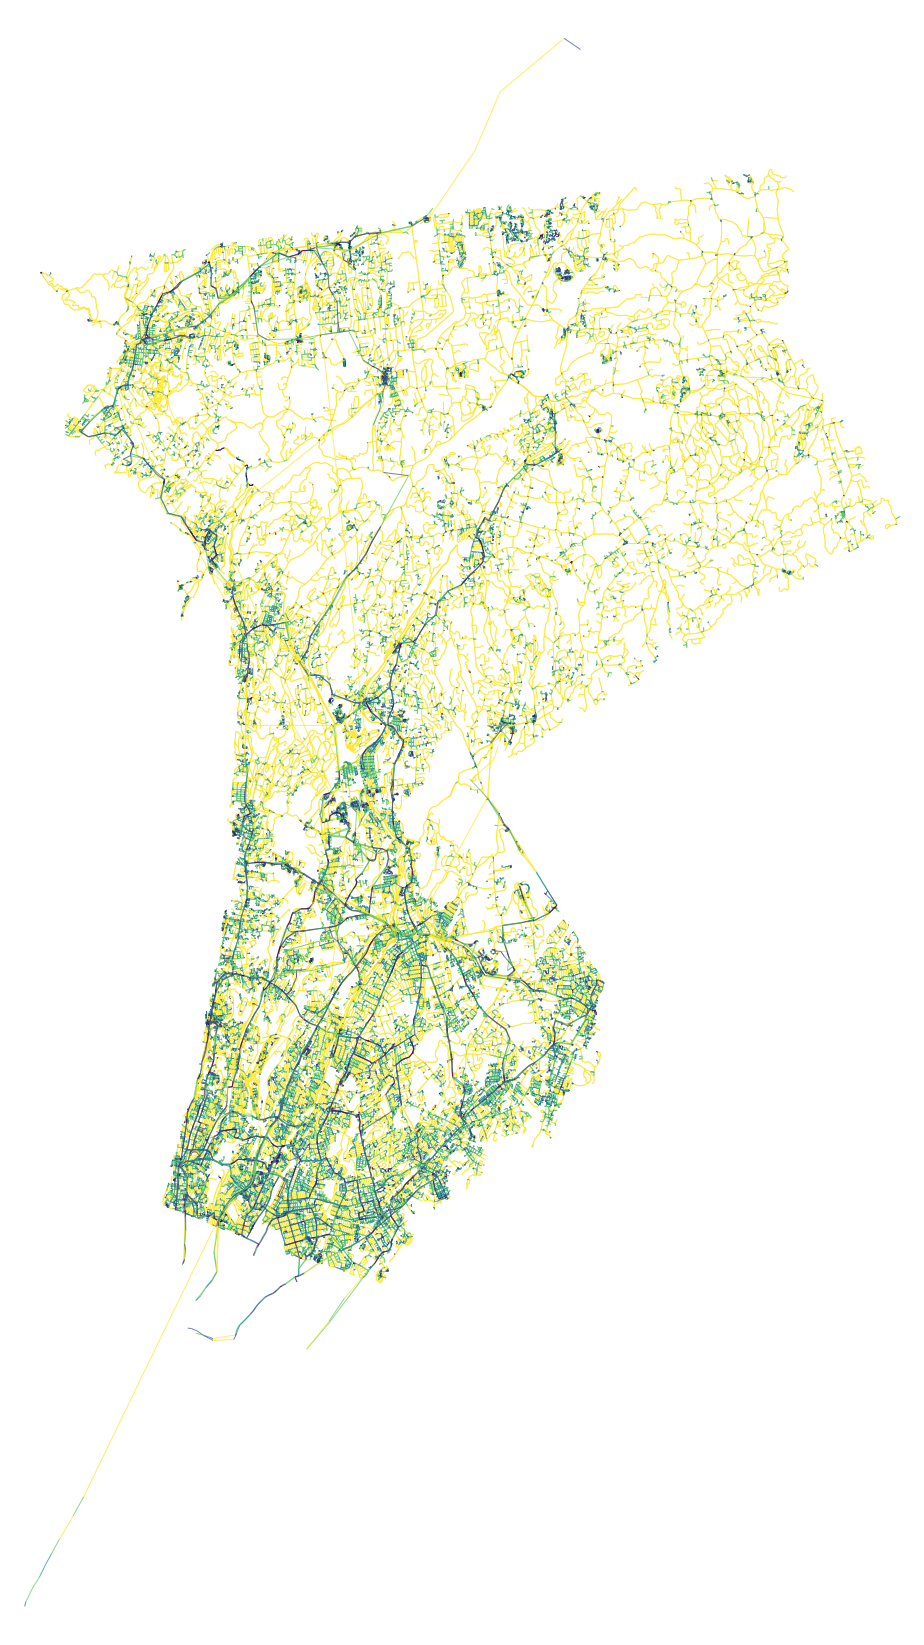

Text(0.5, 1.0, 'Multimodal Network of Westchester County, New York')

In [30]:
# get a colormap for the range of travel time values
ec = ox.get_edge_colors_by_attr(ampeak2, attr='length')

# plot the final multimodal graph
fig, ax = ox.plot_graph(ampeak2, fig_height=30, save=True, file_format='png', 
                        filename='multimodal', node_size=0, edge_color=ec, 
                        edge_alpha=0.7, node_zorder=3)
ax.set_title('Multimodal Network of Westchester County, New York')

## Step 2: Analyzing the network

Now for the more difficult part: let's analyze this network for some accessibility measurements and see just how accessible Westchester County is by walking and bus.

The below is a density measurement of the network, which measures the number of connections per node compared to the total possible connections available in the network.

The density measurement below is incredibly low (close to 0) which means that connectivity is very low. This makes sense in a large network like this.

In [31]:
density = nx.density(ampeak2)
print("Network density is", density)

Network density is 6.014565751313661e-05


To compute some accessibility measurements, a library called pandana (**pand**as for **n**etwork **a**nalysis) was developed by UDST of the company UrbanSim in Berkeley, California. Although the metrics available in pandana are very useful, it requires breaking down the network into nodes and edges dataframes, which the below code shows. 

In [32]:
# convert nodes to dataframe
def create_nodes_df(G):
    data={}
    data['node']=[x[0] for x in G.nodes(data=True)]
    data['x'] = [x[1]['x'] for x in G.nodes(data=True)]
    data['y'] = [x[1]['y'] for x in G.nodes(data=True)]
    #data['osmid'] = [x[1]['osmid'] for x in G.nodes(data=True)]
    #data['boarding_cost'] = [x[1]['boarding_cost'] for x in G.nodes(data=True)]
    df1 = pd.DataFrame(data)
    
    return df1

nodes_df = create_nodes_df(ampeak2)
nodes_df['node'] = nodes_df['node'].astype('int64')
#nodes_df.set_index('node', inplace= True)
nodes_df.head()

,node,x,y
0,254803973,-73.847934,41.049363
1,254803979,-73.848328,41.050304
2,3124756494,-73.788852,41.134909
3,4813619214,-73.769205,41.116219
4,254148624,-73.648044,41.251464


In [33]:
# convert edges to dataframe
def create_edges_df(G):
    edges_ref = {}
    edges_ref['source']=[x[0] for x in G.edges(data=True)]
    edges_ref['target'] = [x[1] for x in G.edges(data=True)]
    edges_ref['length'] = [x[2]['length'] for x in G.edges(data=True)]
    
    edges_df = pd.DataFrame(edges_ref)
    
    edges_df['source'] = edges_df['source'].astype('int64')
    edges_df['target'] = edges_df['target'].astype('int64')

#     edges_df['weight'] = round(edges_df.length)
#     edges_df['weight'] = edges_df.weight.astype('int64')
    
    return edges_df

# edges_df = nx.to_pandas_edgelist(ampeak2)
# edges_df['source'] = edges_df['source'].astype('int64')
# edges_df['target'] = edges_df['target'].astype('int64')

edges_df = create_edges_df(ampeak2)
edges_df.head()

,source,target,length
0,254803973,254803979,127.776
1,254803973,254780086,118.207
2,254803973,254886317,129.513
3,254803979,254803973,127.776
4,3124756494,3124756950,81.401


The below steps are just for the dataframes to work with pandana. They don't otherwise for an unknown reason.

In [34]:
# for some reason, if I don't do this I can't load the network into pandana
nodes_df.to_hdf('test.h5', 'nodes', mode='a', format='table')
edges_df.to_hdf('test.h5', 'edges', mode='a', format='table')
print("HDF file created successfully")

HDF file created successfully


In [35]:
# reopen the HDF file I just made
store = pd.HDFStore('test.h5', "r")
nodes = store.nodes
nodes = nodes.set_index('node')
edges = store.edges
print(nodes.head(3))
print(edges.head(3))

                    x          y
node                            
254803973  -73.847934  41.049363
254803979  -73.848328  41.050304
3124756494 -73.788852  41.134909
      source     target   length
0  254803973  254803979  127.776
1  254803973  254780086  118.207
2  254803973  254886317  129.513


We can now initialize the pandana network using all of the information from the nodes and edges dataframes. The precompute step allows for caching results up to a certain distance for faster processing.

In [36]:
import pandana as pdna
net = pdna.Network(nodes['x'], nodes['y'],
                   edges['source'], edges['target'],
                   edges[['length']])
net.precompute(3600)
print("Pandana network successfully initialized.")

Pandana network successfully initialized.


Hooray, it works! Let's start some accessibility measures. Since I have access to the OSM API with the OSMnx library, I can download the locations of amenities that OSM marks in its database for Westchester County. There are many amenities, but I chose to do doctors offices, clinics, restaurants, cafes, schools, banks, pharmacies, libaries, and cinemas.

The below step pulls the points from OSM, loads them into a geodataframe and saves it as a CSV for easier loading later.

In [37]:
# let's pull some points of interest/amenities to use for accessibility

amenities = ['doctors', 'clinic', 'restaurant','cafe','school','bank','pharmacy', 'library', 'cinema']
poi_filename = 'wc_pois.csv'

if os.path.isfile(poi_filename):
    # if a poi file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    pois = ox.pois.pois_from_place('Westchester County, New York, USA', amenities)
    
    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois = pois[pd.notnull(pois['amenity'])]
    pois = pois.reset_index()

    try:
        pois['lat'] = pois.geometry.y
        pois['lon'] = pois.geometry.x
    except:
        pois['lat'] = pois.geometry.centroid.y
        pois['lon'] = pois.geometry.centroid.x
    
    pois.set_index('index')
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    
print(len(pois), "POIs")
pois[['amenity', 'name', 'lat', 'lon']].head()

1238 POIs


,amenity,name,lat,lon
0,school,Tappan Zee High School,41.049083,-73.954016
1,school,Abbott School,41.043708,-73.858746
2,school,Annunciation School,40.969820,-73.820689
3,school,Archbishop Stepinac High School,41.007875,-73.753465
4,school,Avery School,41.084263,-73.798744


Let's look at how many of each amenity we found.

In [38]:
pois['amenity'].value_counts()

school        683
restaurant    267
bank           80
library        77
pharmacy       51
cafe           49
cinema         15
doctors         9
clinic          7
Name: amenity, dtype: int64

We can now set these POIs onto the pandana network for querying for accessibility. I set the maximum distance to 1200 seconds, which is about 20 minutes of travel time, and the maximum number of POIs per node to 10.

In [39]:
# This is supposed to do something, but it doesn't?
#net.init_pois(num_categories=len(amenities)+1)

net.set_pois(category='all', maxdist=1200, maxitems=10, x_col=pois['lon'], y_col=pois['lat'])
print("POIs set.")

POIs set.


Let's get a table for the distance (in travel time of seconds) from every node in the network to the 10 nearest POIs.

In [40]:
# searches for the 10 nearest amenities of any type to each node in the network
all_access = net.nearest_pois(distance=1200, category='all', num_pois=10)

# the cells represents the network distance from the node the given POI
print(len(all_access), "nodes")
all_access.head()

43412 nodes


,1,2,3,4,5,6,7,8,9,10
node,,,,,,,,,,
254803973,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00,1200.000000
254803979,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00,1200.000000
3124756494,313.493011,313.493011,424.971985,446.544006,491.869995,499.828003,593.458984,668.330994,676.75,711.552979
4813619214,958.703003,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00,1200.000000
254148624,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00,1200.000000


Cool! Now let's plot the travel time from every node to their nearest amenity, regardless of what it is.

Pandana requires a bounding box for setting its data and needs an aspect ratio for sizing.

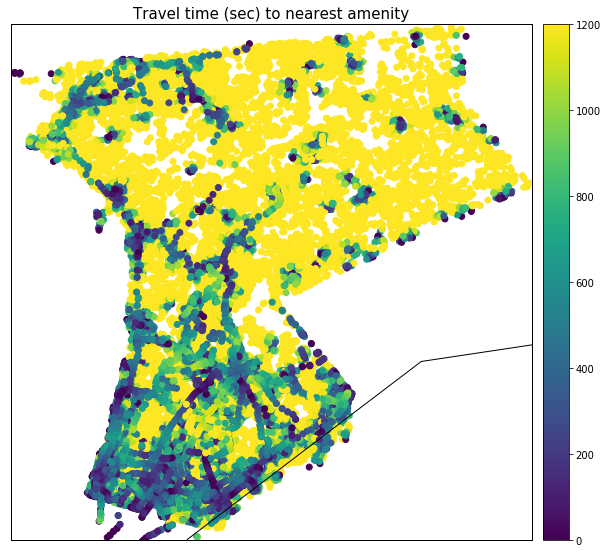

In [41]:
# plot every node with travel time to the nearest amenity
bbox=(40.871721,-73.983284,41.366375,-73.482695)
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
bmap, fig, ax = net.plot(all_access[1], bbox=bbox, fig_kwargs={'figsize':(10, 10 * bbox_aspect_ratio)})

ax.set_title('Travel time (sec) to nearest amenity', fontsize=15);
fig.savefig('accessibility-all.png', dpi=300, bbox_inches='tight')

Super cool. But to measure accessibility, it's more than just the distance to the nearest amenity. Let's see the distance to the 5th nearest amenity.

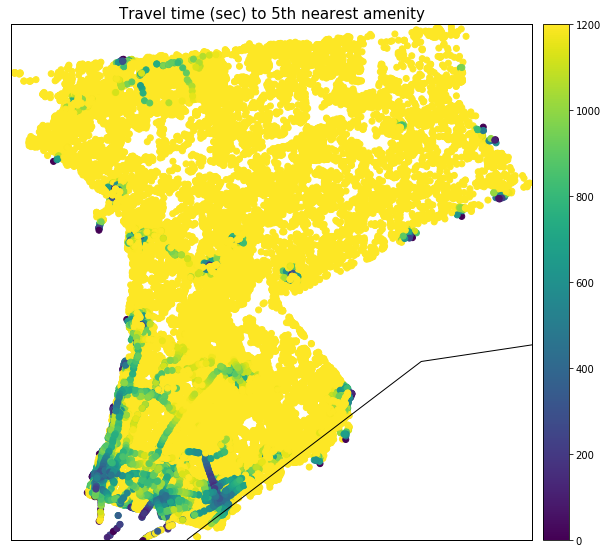

In [42]:
# plot every node with travel time to the 5th nearest amenity
bmap, fig, ax = net.plot(all_access[5], bbox=bbox, fig_kwargs={'figsize':(10, 10 * bbox_aspect_ratio)})

ax.set_title('Travel time (sec) to 5th nearest amenity', fontsize=15);
fig.savefig('accessibility-5th.png', dpi=300, bbox_inches='tight')

We can also do accessibility plots for specific amenities. Let's reset the POIs on the network now classified under categories for what that amenity is.

In [43]:
for amenity in amenities:
    pois_subset = pois[pois['amenity'] == amenity]
    net.set_pois(category=amenity, maxdist=1200, maxitems=10, x_col=pois_subset['lon'], y_col=pois_subset['lat'])
print("POIs set.")

POIs set.


I could do all of the amenities, but let's schools, again with the same distance parameter of 15 minutes and the same maximum number of POIs of 10.

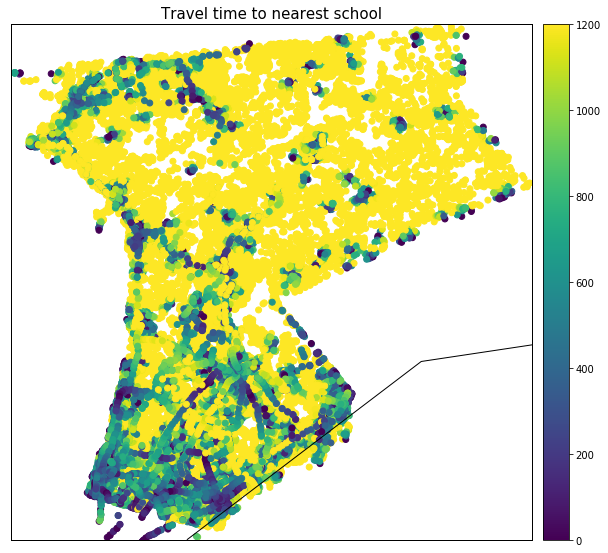

In [44]:
# distance to the nearest school
school_access = net.nearest_pois(distance=1200, category='school', num_pois=10)
bmap, fig, ax = net.plot(school_access[1], bbox=bbox, fig_kwargs={'figsize':(10, 10 * bbox_aspect_ratio)})

ax.set_title('Travel time to nearest school', fontsize=15);
fig.savefig('accessibility-schools.png', dpi=300, bbox_inches='tight')

Pretty neat. The next thing I wanted to do was to do cumulative accessibility measurements using the aggregation method of pandana along the network. 

There was a lot I could have done here, but lack of time and very frustrating errors caused me to use a simple case. I decided to try and use census data and see how many jobs are accessible within 15, 30, and 45 minutes in the network. This involved getting census blocks, job data for Westchester County, joining them, adding them to the network, and doing the aggregation.

In [45]:
# read the 2010 census block shapefile
blocks = gpd.read_file('data/wctigblk10.shp')
blocks['GEOID10'] = blocks['GEOID10'].astype('int64')
print(len(blocks), "blocks loaded")
blocks.head()

15170 blocks loaded


,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,SHAPE_AREA,SHAPE_LEN,geometry
0,36,119,012600,1020,361190126001020,Block 1020,G5040,None,None,S,2400,0,+41.2343264,-073.6181953,2.583503e+04,862.535752,"POLYGON ((734529.4930573441 875724.8678677753,..."
1,36,119,014606,3037,361190146063037,Block 3037,G5040,None,None,S,0,24420,+41.2631872,-073.8542098,2.628162e+05,2319.464732,"POLYGON ((669538.0702189244 886245.7923639417,..."
2,36,119,011500,2025,361190115002025,Block 2025,G5040,None,None,S,6761,0,+41.0656366,-073.8676097,7.276101e+04,2302.593374,"POLYGON ((666460.8020952605 813331.0421963558,..."
3,36,119,010801,2002,361190108012002,Block 2002,G5040,None,None,S,565815,0,+41.0156165,-073.8174329,6.089628e+06,14803.039149,"POLYGON ((681732.89950376 794569.3326726109, 6..."
4,36,119,012600,1027,361190126001027,Block 1027,G5040,None,None,S,39099,0,+41.2346437,-073.6170940,4.208332e+05,3271.099208,"POLYGON ((734868.8660662584 875242.2405521944,..."


In [46]:
# jobs csv from LEHD -- filter for Westchester blocks
jobs = pd.read_csv('data/lehd/ny_od_main_JT00_2015.csv')
blocklist = list(blocks['GEOID10'])
jobs_wc = jobs[jobs['w_geocode'].isin(blocklist)]
jobs_wc['w_geocode'] = jobs_wc['w_geocode'].astype('int64')
jobs_wc.head()

C:\Users\Deana\Anaconda3\envs\gtech733\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
7058794,361190001011000,360050223002000,1,0,1,0,0,1,0,0,0,1,20170919
7058795,361190001011000,360050399022000,1,0,1,0,0,1,0,0,1,0,20170919
7058796,361190001011000,360271407001020,1,0,1,0,1,0,0,0,1,0,20170919
7058797,361190001011000,360610285002000,1,0,1,0,0,1,0,0,0,1,20170919
7058798,361190001011000,360790103004031,1,0,1,0,1,0,0,0,1,0,20170919


In [47]:
# join the blocks shapefile with the jobs CSV
joined_blocks = blocks.merge(jobs_wc, left_on=['GEOID10'], right_on=['w_geocode'])
joined_blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,FUNCSTAT10,...,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,36,119,010801,2002,361190108012002,Block 2002,G5040,None,None,S,...,0,1,0,1,0,0,0,1,0,20170919
1,36,119,010801,2002,361190108012002,Block 2002,G5040,None,None,S,...,0,0,1,0,0,1,0,1,0,20170919
2,36,119,010801,2002,361190108012002,Block 2002,G5040,None,None,S,...,0,1,0,0,0,1,0,1,0,20170919
3,36,119,010801,2002,361190108012002,Block 2002,G5040,None,None,S,...,0,1,0,0,0,1,0,1,0,20170919
4,36,119,010801,2002,361190108012002,Block 2002,G5040,None,None,S,...,0,1,0,0,0,1,0,1,0,20170919


In [48]:
# pull the centroid of the census blocks for the latitude and longtitudes
joined_blocks = joined_blocks.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
joined_blocks['lat'] = joined_blocks.geometry.centroid.y
joined_blocks['lon'] = joined_blocks.geometry.centroid.x

joined_blocks = joined_blocks[['w_geocode', 'S000', 'lat', 'lon']]
joined_blocks.head()

,w_geocode,S000,lat,lon
0,361190108012002,1,41.015617,-73.817433
1,361190108012002,1,41.015617,-73.817433
2,361190108012002,1,41.015617,-73.817433
3,361190108012002,1,41.015617,-73.817433
4,361190108012002,1,41.015617,-73.817433


In [49]:
# drop all the duplicate block entries
joined_blocks.drop_duplicates(keep='first', inplace=True)
joined_blocks.head()

,w_geocode,S000,lat,lon
0,361190108012002,1,41.015617,-73.817433
21,361190109011034,1,41.052665,-73.790714
23,361190112002048,1,41.050938,-73.803106
45,361190050011002,1,40.978068,-73.800350
48,361190050011009,1,40.976332,-73.799391


Okay great. We can now join these points with the nodes in the pandana network so they obtain these attributes from this dataframe.

In [50]:
# set the bounding box
lng_max, lat_min, lng_min, lat_max = bbox

# join the job attributes to the nodes
joined_blocks['node_id'] = net.get_node_ids(joined_blocks['lon'], joined_blocks['lat'])
joined_blocks['node_id'].nunique()

6175

In [51]:
joined_blocks.head()

,w_geocode,S000,lat,lon,node_id
0,361190108012002,1,41.015617,-73.817433,254241892
21,361190109011034,1,41.052665,-73.790714,254165180
23,361190112002048,1,41.050938,-73.803106,364832193
45,361190050011002,1,40.978068,-73.800350,254202449
48,361190050011009,1,40.976332,-73.799391,254655768


In [52]:
# set the attributes to the network for aggregation
joined_blocks['S000'] = joined_blocks['S000'].astype(float)

net.set(joined_blocks.node_id, variable=joined_blocks.S000, name='jobs')

Alright let's run the aggregations for jobs within 15, 30, and 45 minutes along the network.

In [53]:
jobs15 = net.aggregate(900, type='sum', decay='linear', name='jobs')
jobs30 = net.aggregate(1800, type='sum', decay='linear', name='jobs')
jobs45 = net.aggregate(2700, type='sum', decay='linear', name='jobs')

In [54]:
jobs15.head()

node
254803973      1.591772
254803979      1.023879
3124756494    30.961361
4813619214     1.249721
254148624      0.000000
dtype: float64

In [55]:
jobs30.head()

node
254803973      7.684382
254803979      5.909715
3124756494    65.915603
4813619214    14.497467
254148624      0.741792
dtype: float64

In [56]:
jobs45.head()

node
254803973     20.033683
254803979     16.632283
3124756494    93.319111
4813619214    36.780016
254148624      3.261082
dtype: float64

Let's visualize the jobs that are accessible in 15 minutes.

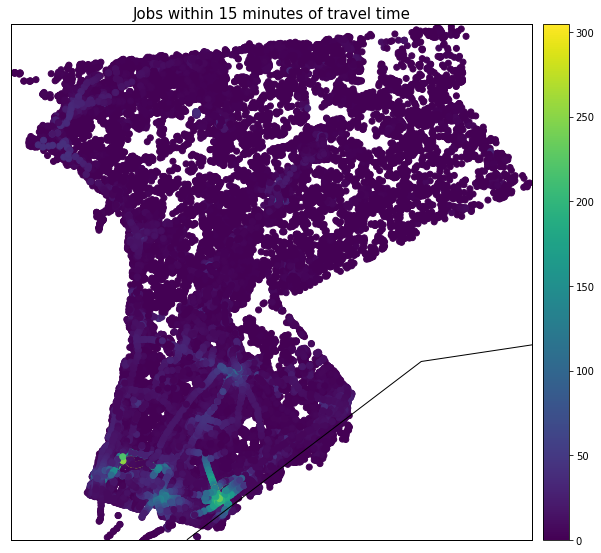

In [57]:
bmap, fig, ax = net.plot(jobs15, plot_type='scatter',bbox=bbox, fig_kwargs={'figsize':(10, 10 * bbox_aspect_ratio)});

ax.set_title("Jobs within 15 minutes of travel time", fontsize=15)
fig.savefig('jobs15.png', dpi=300, bbox_inches='tight')

We can do the same thing for jobs within 30 minutes and within 45 minutes.

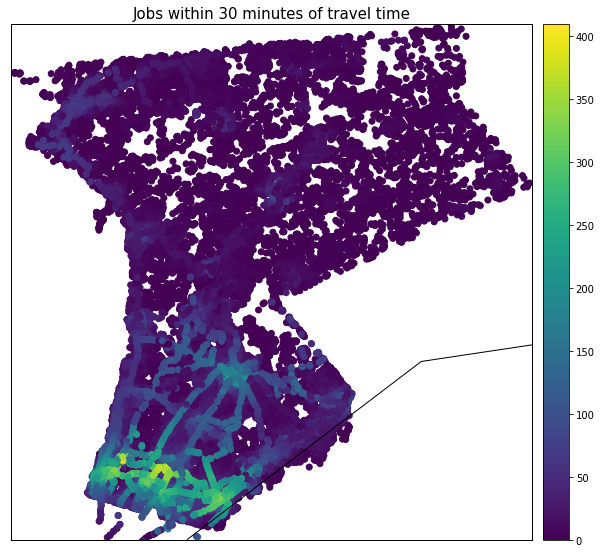

In [58]:
bmap, fig, ax = net.plot(jobs30, plot_type='scatter',bbox=bbox, fig_kwargs={'figsize':(10, 10 * bbox_aspect_ratio)});

ax.set_title("Jobs within 30 minutes of travel time", fontsize=15)
fig.savefig('job30.png', dpi=300, bbox_inches='tight')

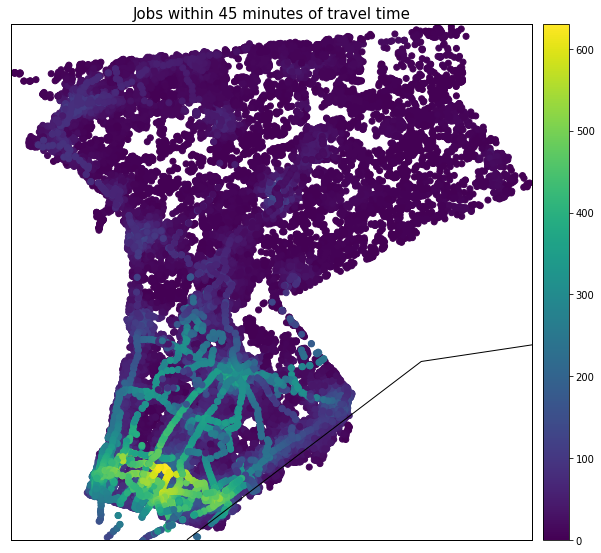

In [59]:
bmap, fig, ax = net.plot(jobs45, plot_type='scatter',bbox=bbox, fig_kwargs={'figsize':(10, 10 * bbox_aspect_ratio)});

ax.set_title("Jobs within 45 minutes of travel time", fontsize=15)
fig.savefig('jobs45.png', dpi=300, bbox_inches='tight')

## Conclusions

- Networks are hard.
- Don't underestimate the computational intensity required for network analyses
- This is probably an analysis best suited for a smaller region to allow for better visualizations.
- The southern region of Westchester seems to have better accessibility than northern Westchester, but also Southern Westchester has a larger population, and potentially a greater population density and less rich people.
- Would be very interesting to get this to work with more census data for querying socioeconomic factors and creating transit needs for each census block.
- So much potential!!

# Thank you!!

~Deana